# Brats2020 Basic Pytorch

For a more advanced version see: https://www.kaggle.com/polomarco/brats20-3dunet-3dautoencoder

Sources

https://github.com/panxiaobai/lits_pytorch

https://www.kaggle.com/bibhasmondal96/lung-segmentation-pytorch-unet3d

https://gitee.com/langlibaihu/UNet3D-Pytorch




In [1]:
import pandas as pd
from tqdm.notebook import tqdm

In [2]:


import json
import random
from pathlib import Path
from joblib import Parallel, delayed

* Note - need to fix script that populates BRATS as training point 355 has a bad segmentation file name.

## Destination Directory

In [3]:
!pwd

/media/SSD/BraTS2020


In [4]:
destination = Path("/media/SSD/BraTS2020/data")
destination.mkdir(parents=True, exist_ok=True)
(destination/"Training").mkdir(parents=True, exist_ok=True)
(destination/"Validation").mkdir(parents=True, exist_ok=True)
(destination/"Testing").mkdir(parents=True, exist_ok=True)

model_out_path = Path("models/")
model_out_path.mkdir(parents=True, exist_ok=True)


In [5]:
#data_df.to_csv(destination/"data_df.csv")
data_df = pd.read_csv(destination/"data_df.csv")  

In [6]:

#data_df[data_df['subject.mlset']=='Training']['file.name-segmentation'].values

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from skimage.util import montage
import torch
torch.__version__

'1.8.1+cu102'

# Pytorch Dataloader

Uses single modality

In [8]:
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform

        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        ml_set = self.df.iloc[idx]['subject.mlset']
        image_file_name = self.df.iloc[idx]['file.name-image']
        mask_file_name = self.df.iloc[idx]['file.name-segmentation']
        
        img_path = self.path/ml_set/image_file_name
        mask_path =  self.path/ml_set/mask_file_name
        
        img = self.load_img(img_path)
        img = self.resize(img)
        img = self.normalize(img)
        img = np.moveaxis(img, (0, 1, 2), (2, 1, 0))
        img = np.expand_dims(img, axis=0)
        
        mask = self.load_img(mask_path)
        mask = self.resize(mask)
        mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
        mask = np.clip(mask, 0, 1)
        mask = self.preprocess_mask_labels(mask)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
    
    
        
        return {
            "image": img,
            "mask": mask,
        }
        
        
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj,dtype=np.float32)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (38, 60, 60), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_NCR = mask.copy()
        mask_NCR[mask_NCR == 1] = 1
        mask_NCR[mask_NCR == 2] = 0
        mask_NCR[mask_NCR == 4] = 0

        mask_ED = mask.copy()
        mask_ED[mask_ED == 1] = 0
        mask_ED[mask_ED == 2] = 1
        mask_ED[mask_ED == 4] = 0

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_NCR, mask_ED, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask



In [9]:
train_dataset = Dataset_from_df(data_df[data_df['subject.mlset']=='Training'],destination)
valid_dataset = Dataset_from_df(data_df[data_df['subject.mlset']=='Validation'],destination)

In [10]:
train_dataset[0]['image'].shape, train_dataset[0]['mask'].shape

((1, 60, 60, 38), (3, 60, 60, 38))

In [11]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=4,
                                               num_workers=4,
                                               pin_memory=True,
                                               shuffle=True)

In [12]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                    batch_size=4,
                                                    num_workers=4,
                                                    pin_memory=True,
                                                    shuffle=True)


In [13]:
data = next(iter(train_dataloader))

In [14]:
data['image'].shape, data['mask'].shape

(torch.Size([4, 1, 60, 60, 38]), torch.Size([4, 3, 60, 60, 38]))

Num uniq Image values : 34121
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([409677,    723]))


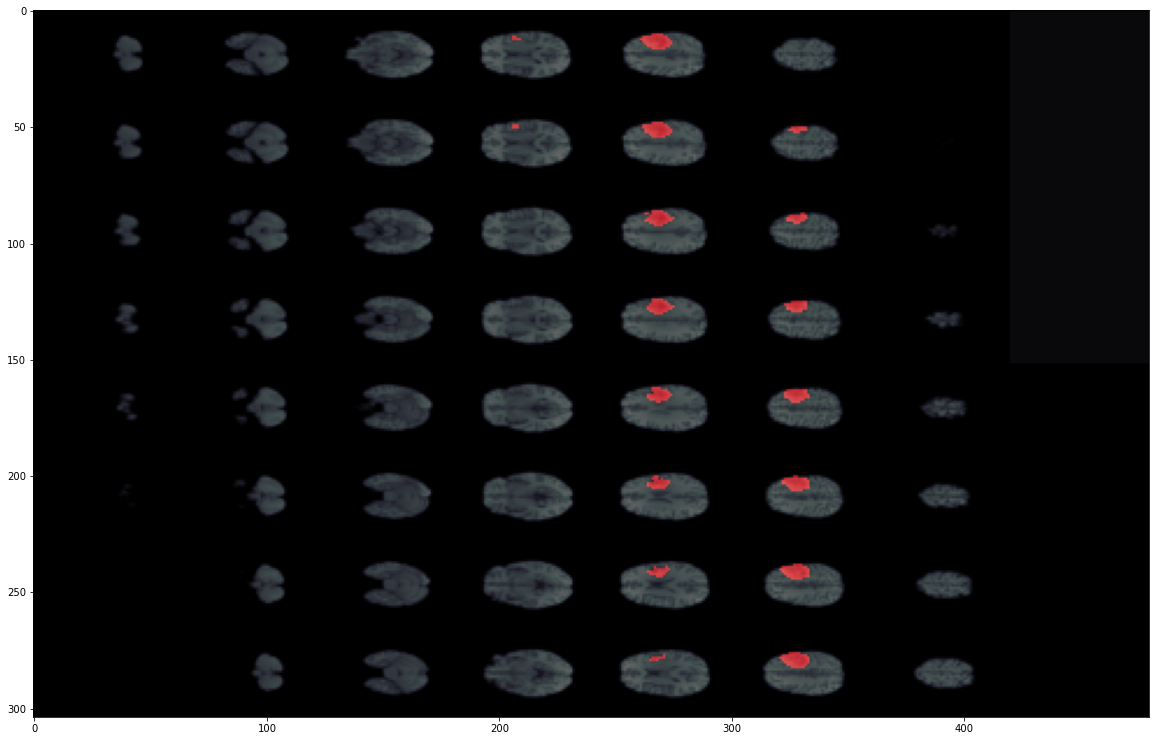

In [15]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
mask_tensor = np.moveaxis(mask_tensor, 0,3)
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor,multichannel=True)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),cmap='cool', alpha=0.6)

In [16]:
img_tensor.shape,mask_tensor.shape

((60, 60, 38), (60, 60, 38, 3))

In [ ]:
image.shape,mask.shape

## UNET 3D

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

In [50]:
#model = UNet3d(in_channels=1, n_classes=3, n_channels=16).to('cuda')
model = UNet3d(in_channels=1, n_classes=3, n_channels=24).to('cuda')
model_name_base = "UNET3D_24"

## Training and Validation Loops

In [51]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):

    #lr = adjust_learning_rate(optimizer, epoch-epoch_start)

    #for param_group in optimizer.param_groups:
    #   param_group["lr"] = lr

    #print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        output = model(images)

        loss = loss_fn(masks, output)


        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            #metric += metric_fn(output,masks) * images.size(0)

        pbar.update(1)
    pbar.close()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [52]:
def train_mp(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model, use_amp, scaler):

    #lr = adjust_learning_rate(optimizer, epoch-epoch_start)

    #for param_group in optimizer.param_groups:
    #   param_group["lr"] = lr

    #print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        with torch.cuda.amp.autocast(enabled=use_amp):
            images = images.cuda(non_blocking=True)
            masks = masks.cuda(non_blocking=True)

            output = model(images)

            loss = loss_fn(masks, output)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            #metric += metric_fn(output,masks) * images.size(0)

        pbar.update(1)
    pbar.close()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [53]:
def validatef32(valid_dataloader, loss_fn, metric_fn, model):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        output = model(images)
        with torch.no_grad():
            loss = loss_fn(masks, output)
            validation_loss += loss.data.item() * images.size(0)
        
            #metric += metric_fn(output,masks) * images.size(0)
        pbar.update(1)
    pbar.close()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

In [54]:
def validate_mp(valid_dataloader, loss_fn, metric_fn, model, use_amp):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']
        with torch.cuda.amp.autocast(enabled=use_amp):
            images = images.cuda(non_blocking=True)
            masks = masks.cuda(non_blocking=True)

            output = model(images)
            with torch.no_grad():
                loss = loss_fn(masks, output)
                validation_loss += loss.data.item() * images.size(0)
        
            #metric += metric_fn(output,masks) * images.size(0)
        pbar.update(1)
    pbar.close()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

In [55]:
init_lr = .00001
epochs=100
use_amp = True # Use Mixed Precision

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

In [57]:
def torch_dice_coef_loss(y_true,y_pred):
    smooth = 1.0
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return 1. - ((2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth))

In [58]:
class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss

In [59]:
#loss_fn = torch_dice_coef_loss
loss_fn = BCEDiceLoss()

In [60]:
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)

In [61]:
from sklearn.metrics import f1_score, accuracy_score


def f1_torch(preds, target):
    np_target = target.to("cpu").to(torch.int).numpy()
    np_preds = preds.to("cpu").to(torch.int).numpy()
    return f1_score(np_target, np_preds, average="micro", zero_division=0)


def accuracy_torch(preds, target):
    np_target = target.to("cpu").to(torch.int).numpy()
    np_preds = preds.to("cpu").to(torch.int).numpy()
    return accuracy_score(np_target, np_preds)

BCELoss_metric_fn = torch.nn.BCELoss()

## Training Loop

In [ ]:
best_validation_loss = 999

for epoch in range(1, epochs + 1):

    lr = lr_scheduler.get_last_lr()
    print('Epoch: {}, LR: {:.3e}'.format(epoch, lr[0]), end="--")

    training_loss, training_metric = trainfp32(epoch,
                                               train_dataloader,
                                               optimizer,
                                               loss_fn,
                                               lr_scheduler,
                                               metric_fn=BCELoss_metric_fn,
                                               model=model)

    print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
        training_loss, training_metric),
          end=',')
    validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                      loss_fn=loss_fn,
                                                      metric_fn=BCELoss_metric_fn,
                                                      model=model)

    if validation_loss < best_validation_loss:
        model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
        torch.save(model.state_dict(), model_out_str)
        
    print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
        validation_loss, validation_metric))

In [62]:
best_validation_loss = 999
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
for epoch in range(1, epochs + 1):

    lr = lr_scheduler.get_last_lr()
    print('Epoch: {}, LR: {:.3e}'.format(epoch, lr[0]), end="--")

    training_loss, training_metric = train_mp(epoch,
                                               train_dataloader,
                                               optimizer,
                                               loss_fn,
                                               lr_scheduler,
                                               metric_fn=BCELoss_metric_fn,
                                               model=model,
                                               use_amp=True,
                                               scaler=scaler)

    print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
        training_loss, training_metric),
          end=',')
    validation_loss, validation_metric = validate_mp(valid_dataloader,
                                                      loss_fn=loss_fn,
                                                      metric_fn=BCELoss_metric_fn,
                                                      model=model,
                                                      use_amp=True)

    if validation_loss < best_validation_loss:
        model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
        torch.save(model.state_dict(), model_out_str)
        
    print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
        validation_loss, validation_metric))

Epoch: 1, LR: 4.000e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.5258, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.4431, Metric = 0.000
Epoch: 2, LR: 4.263e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.3934, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.3502, Metric = 0.000
Epoch: 3, LR: 5.050e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.3226, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.2951, Metric = 0.000
Epoch: 4, LR: 6.351e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.2736, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.2513, Metric = 0.000
Epoch: 5, LR: 8.154e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.2320, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.2121, Metric = 0.000
Epoch: 6, LR: 1.044e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.1938, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.1754, Metric = 0.000
Epoch: 7, LR: 1.318e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.1596, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.1451, Metric = 0.000
Epoch: 8, LR: 1.634e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.1328, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.1217, Metric = 0.000
Epoch: 9, LR: 1.990e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.1129, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33ceffe310>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33ceffe310>
Traceback (most recent call last):
  File "/media/SSD/conda_env/fastaiv2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/media/SSD/conda_env/fastaiv2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1279, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/media/SSD/conda_env/fastaiv2/lib/python3.9/threading.py", line 1030, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
  File "/media/SSD/conda_env/fastaiv2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/media/SSD/conda_env/fastaiv2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 

Validation-- Loss: 1.1056, Metric = 0.000
Epoch: 10, LR: 2.380e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0996, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0946, Metric = 0.000
Epoch: 11, LR: 2.802e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0897, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0854, Metric = 0.000
Epoch: 12, LR: 3.250e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0817, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0791, Metric = 0.000
Epoch: 13, LR: 3.719e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0763, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0746, Metric = 0.000
Epoch: 14, LR: 4.205e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0721, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0707, Metric = 0.000
Epoch: 15, LR: 4.701e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0686, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0675, Metric = 0.000
Epoch: 16, LR: 5.203e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0655, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0646, Metric = 0.000
Epoch: 17, LR: 5.705e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0626, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0619, Metric = 0.000
Epoch: 18, LR: 6.202e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0599, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0591, Metric = 0.000
Epoch: 19, LR: 6.687e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0572, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0565, Metric = 0.000
Epoch: 20, LR: 7.156e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0545, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0538, Metric = 0.000
Epoch: 21, LR: 7.604e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0518, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0511, Metric = 0.000
Epoch: 22, LR: 8.025e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0490, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0484, Metric = 0.000
Epoch: 23, LR: 8.416e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0464, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0457, Metric = 0.000
Epoch: 24, LR: 8.771e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0435, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0430, Metric = 0.000
Epoch: 25, LR: 9.086e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0409, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0402, Metric = 0.000
Epoch: 26, LR: 9.360e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0381, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0380, Metric = 0.000
Epoch: 27, LR: 9.587e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0354, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0351, Metric = 0.000
Epoch: 28, LR: 9.767e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0326, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0324, Metric = 0.000
Epoch: 29, LR: 9.896e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0297, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0302, Metric = 0.000
Epoch: 30, LR: 9.974e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0272, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0269, Metric = 0.000
Epoch: 31, LR: 1.000e-05--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0244, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0243, Metric = 0.000
Epoch: 32, LR: 9.995e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0215, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0228, Metric = 0.000
Epoch: 33, LR: 9.980e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0185, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0188, Metric = 0.000
Epoch: 34, LR: 9.954e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0159, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0163, Metric = 0.000
Epoch: 35, LR: 9.919e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0130, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0142, Metric = 0.000
Epoch: 36, LR: 9.874e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0107, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0131, Metric = 0.000
Epoch: 37, LR: 9.819e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0081, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0095, Metric = 0.000
Epoch: 38, LR: 9.754e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0054, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0070, Metric = 0.000
Epoch: 39, LR: 9.680e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0031, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0050, Metric = 0.000
Epoch: 40, LR: 9.596e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 1.0008, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0033, Metric = 0.000
Epoch: 41, LR: 9.504e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9986, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 1.0016, Metric = 0.000
Epoch: 42, LR: 9.402e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9966, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9991, Metric = 0.000
Epoch: 43, LR: 9.291e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9944, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9982, Metric = 0.000
Epoch: 44, LR: 9.171e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9922, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9955, Metric = 0.000
Epoch: 45, LR: 9.043e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9899, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9939, Metric = 0.000
Epoch: 46, LR: 8.907e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9881, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9919, Metric = 0.000
Epoch: 47, LR: 8.763e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9863, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9902, Metric = 0.000
Epoch: 48, LR: 8.612e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9842, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9885, Metric = 0.000
Epoch: 49, LR: 8.453e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9824, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9866, Metric = 0.000
Epoch: 50, LR: 8.287e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9806, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9854, Metric = 0.000
Epoch: 51, LR: 8.115e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9793, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9836, Metric = 0.000
Epoch: 52, LR: 7.936e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9775, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9821, Metric = 0.000
Epoch: 53, LR: 7.752e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9758, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9808, Metric = 0.000
Epoch: 54, LR: 7.562e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9744, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9798, Metric = 0.000
Epoch: 55, LR: 7.367e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9728, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9784, Metric = 0.000
Epoch: 56, LR: 7.167e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9714, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9770, Metric = 0.000
Epoch: 57, LR: 6.962e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9701, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9763, Metric = 0.000
Epoch: 58, LR: 6.754e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9688, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9745, Metric = 0.000
Epoch: 59, LR: 6.542e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9674, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9744, Metric = 0.000
Epoch: 60, LR: 6.327e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9664, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9727, Metric = 0.000
Epoch: 61, LR: 6.110e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9652, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9711, Metric = 0.000
Epoch: 62, LR: 5.890e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9639, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9705, Metric = 0.000
Epoch: 63, LR: 5.668e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9629, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9701, Metric = 0.000
Epoch: 64, LR: 5.445e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9618, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9691, Metric = 0.000
Epoch: 65, LR: 5.221e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9610, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9674, Metric = 0.000
Epoch: 66, LR: 4.997e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9599, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9669, Metric = 0.000
Epoch: 67, LR: 4.773e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9589, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9663, Metric = 0.000
Epoch: 68, LR: 4.549e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9580, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9659, Metric = 0.000
Epoch: 69, LR: 4.326e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9572, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9648, Metric = 0.000
Epoch: 70, LR: 4.104e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9565, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9644, Metric = 0.000
Epoch: 71, LR: 3.884e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9558, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9641, Metric = 0.000
Epoch: 72, LR: 3.667e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9552, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9628, Metric = 0.000
Epoch: 73, LR: 3.452e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9545, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9620, Metric = 0.000
Epoch: 74, LR: 3.240e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9538, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9621, Metric = 0.000
Epoch: 75, LR: 3.032e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9532, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9616, Metric = 0.000
Epoch: 76, LR: 2.828e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9527, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9616, Metric = 0.000
Epoch: 77, LR: 2.628e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9521, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9607, Metric = 0.000
Epoch: 78, LR: 2.433e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9516, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9604, Metric = 0.000
Epoch: 79, LR: 2.243e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9512, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9600, Metric = 0.000
Epoch: 80, LR: 2.059e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9507, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9596, Metric = 0.000
Epoch: 81, LR: 1.880e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9504, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9593, Metric = 0.000
Epoch: 82, LR: 1.708e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9501, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9590, Metric = 0.000
Epoch: 83, LR: 1.543e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9498, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9589, Metric = 0.000
Epoch: 84, LR: 1.384e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9495, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9586, Metric = 0.000
Epoch: 85, LR: 1.233e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9493, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9584, Metric = 0.000
Epoch: 86, LR: 1.089e-06--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9491, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9583, Metric = 0.000
Epoch: 87, LR: 9.532e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9488, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9582, Metric = 0.000
Epoch: 88, LR: 8.255e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9487, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9580, Metric = 0.000
Epoch: 89, LR: 7.062e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9486, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9579, Metric = 0.000
Epoch: 90, LR: 5.956e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9484, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9578, Metric = 0.000
Epoch: 91, LR: 4.939e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9483, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9578, Metric = 0.000
Epoch: 92, LR: 4.012e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9482, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9577, Metric = 0.000
Epoch: 93, LR: 3.178e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9482, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9577, Metric = 0.000
Epoch: 94, LR: 2.438e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9481, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9576, Metric = 0.000
Epoch: 95, LR: 1.794e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9481, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9576, Metric = 0.000
Epoch: 96, LR: 1.247e-07--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9481, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9576, Metric = 0.000
Epoch: 97, LR: 7.985e-08--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9481, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9576, Metric = 0.000
Epoch: 98, LR: 4.488e-08--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9480, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9576, Metric = 0.000
Epoch: 99, LR: 1.990e-08--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9480, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9576, Metric = 0.000
Epoch: 100, LR: 4.940e-09--

  0%|          | 0/74 [00:00<?, ?it/s]

Training-- Loss: 0.9480, Metric: 0.000,

  0%|          | 0/19 [00:00<?, ?it/s]

Validation-- Loss: 0.9576, Metric = 0.000


## Make Predictions

In [64]:
data = next(iter(valid_dataloader))
output = model(data['image'].cuda())

In [65]:
output.shape

torch.Size([4, 3, 60, 60, 38])

In [66]:
data['mask'].shape

torch.Size([4, 3, 60, 60, 38])

In [67]:
def view_tensor(img_tensor, mask_tensor):
    img_np = img_tensor.squeeze()[0].cpu().detach().numpy() 
    mask_np = mask_tensor.squeeze()[0].squeeze().cpu().detach().numpy()
    mask_np = np.moveaxis(mask_np, 0,3)
    print("Num uniq Image values :", len(np.unique(img_np, return_counts=True)[0]))
    print("Min/Max Image values:", img_np.min(), img_np.max())
    print("Num uniq Mask values:", np.unique(mask_np, return_counts=True))

    image = np.rot90(montage(img_np))
    mask = np.rot90(montage(mask_np,multichannel=True)) 

    fig, ax = plt.subplots(1, 1, figsize = (20, 20))
    ax.imshow(image, cmap ='bone')
    ax.imshow(np.ma.masked_where(mask == False, mask),cmap='cool', alpha=0.6)

Num uniq Image values : 40421
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([409129,   1271]))


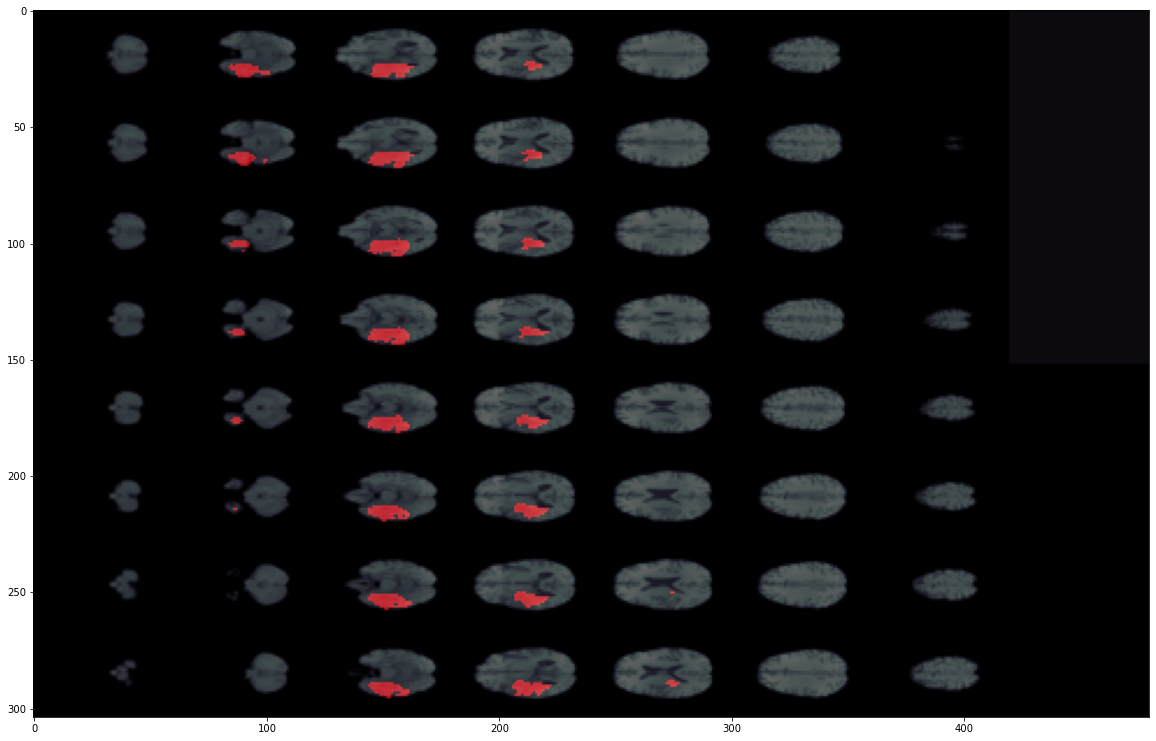

In [68]:
view_tensor(data['image'],data['mask'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Num uniq Image values : 40421
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([-1.662641 , -1.6539781, -1.6532152, ..., 13.727554 , 13.738488 ,
       13.769003 ], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))


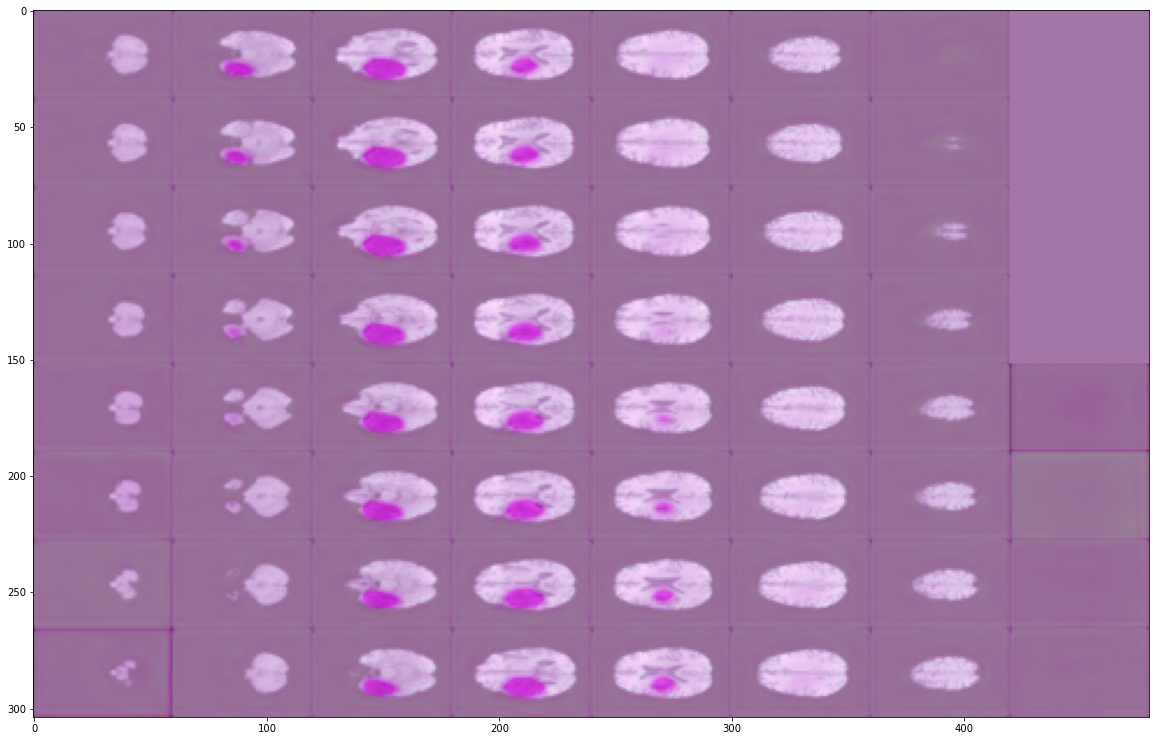

In [69]:
view_tensor(data['image'],output)